In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Loading Dataset

In [3]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

Creating Features

Customer Profile Features

In [4]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
min_date = customers['SignupDate'].min()
customers['account_age_days'] = (customers['SignupDate'] - min_date).dt.days

Transaction based Features

In [5]:
trans_features = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': ['sum', 'mean', 'std'],
    'Quantity': ['sum', 'mean', 'std'],
    'TransactionDate': ['min', 'max']
}).reset_index()

Flatten column names

In [6]:
trans_features.columns = ['CustomerID', 'transaction_count', 
                        'total_value', 'avg_value', 'std_value',
                        'total_quantity', 'avg_quantity', 'std_quantity',
                        'first_purchase', 'last_purchase']

Fil NaN values

In [21]:
trans_features = trans_features.fillna(0)

Calculate product category preference

In [7]:
trans_products = transactions.merge(products[['ProductID', 'Category']], on='ProductID')
category_pivot = pd.pivot_table(
    trans_products,
    values='TotalValue',
    index='CustomerID',
    columns='Category',
    aggfunc='sum',
    fill_value=0
)

Normalize Category Preference

In [8]:
category_preferences = category_pivot.div(category_pivot.sum(axis=1), axis=0)

Calculate RFM features

In [22]:
current_date = pd.to_datetime(transactions['TransactionDate']).max()
rfm = transactions.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (current_date - pd.to_datetime(x.max())).days, 
    'TransactionID': 'count',
    'TotalValue': 'sum' 
}).reset_index()

rfm.columns = ['CustomerID', 'recency', 'frequency', 'monetary']

Merge all features

In [11]:
customer_features = customers.merge(trans_features, on='CustomerID')
customer_features = customer_features.merge(category_preferences.reset_index(), on='CustomerID')
customer_features = customer_features.merge(rfm, on='CustomerID')

Fill any remaining NaN values

In [23]:
customer_features = customer_features.fillna(0)

Feature Processing

In [24]:
numeric_features = ['account_age_days', 'transaction_count', 'total_value', 
                   'avg_value', 'std_value', 'total_quantity', 'avg_quantity', 
                   'std_quantity', 'recency', 'frequency', 'monetary']
categorical_features = ['Region']

Creating pre processing Pipeline

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])


Transform Features

In [29]:
features_processed = preprocessor.fit_transform(customer_features)

In [30]:
print(f"Processed features shape: {features_processed.shape}")

Processed features shape: (199, 14)


Calculate Similarity

In [31]:
print("Calculating similarity matrix...")
similarity_matrix = cosine_similarity(features_processed)
print(f"Similarity matrix shape: {similarity_matrix.shape}")

Calculating similarity matrix...
Similarity matrix shape: (199, 199)


Getting Top lookalikes

In [32]:
print("Finding lookalikes...")
lookalikes = {}
n_recommendations = 3

Finding lookalikes...


Fetching lookalikes for first 20 customers

In [33]:
for i, cust_id in enumerate(customer_features['CustomerID'][:20]):
    similarities = similarity_matrix[i]
    similar_indices = np.argsort(similarities)[-(n_recommendations+1):-1][::-1]
    
    lookalikes[cust_id] = [
        (customer_features['CustomerID'].iloc[idx], round(similarities[idx], 4))
        for idx in similar_indices
    ]

Creating and saving output

In [34]:
lookalike_df = pd.DataFrame.from_dict(
    lookalikes,
    orient='index',
    columns=['1st Similar', '2nd Similar', '3rd Similar']
)
lookalike_df.index.name = 'CustomerID'
lookalike_df.to_csv('Tarushi_Saraj_Lookalike.csv')
print("Results saved to 'Tarushi_Saraj_Lookalike.csv'")

Results saved to 'Tarushi_Saraj_Lookalike.csv'


Now creating Visualizations 

In [35]:
print("Creating visualizations...")

Creating visualizations...


Making the similarity heatmap

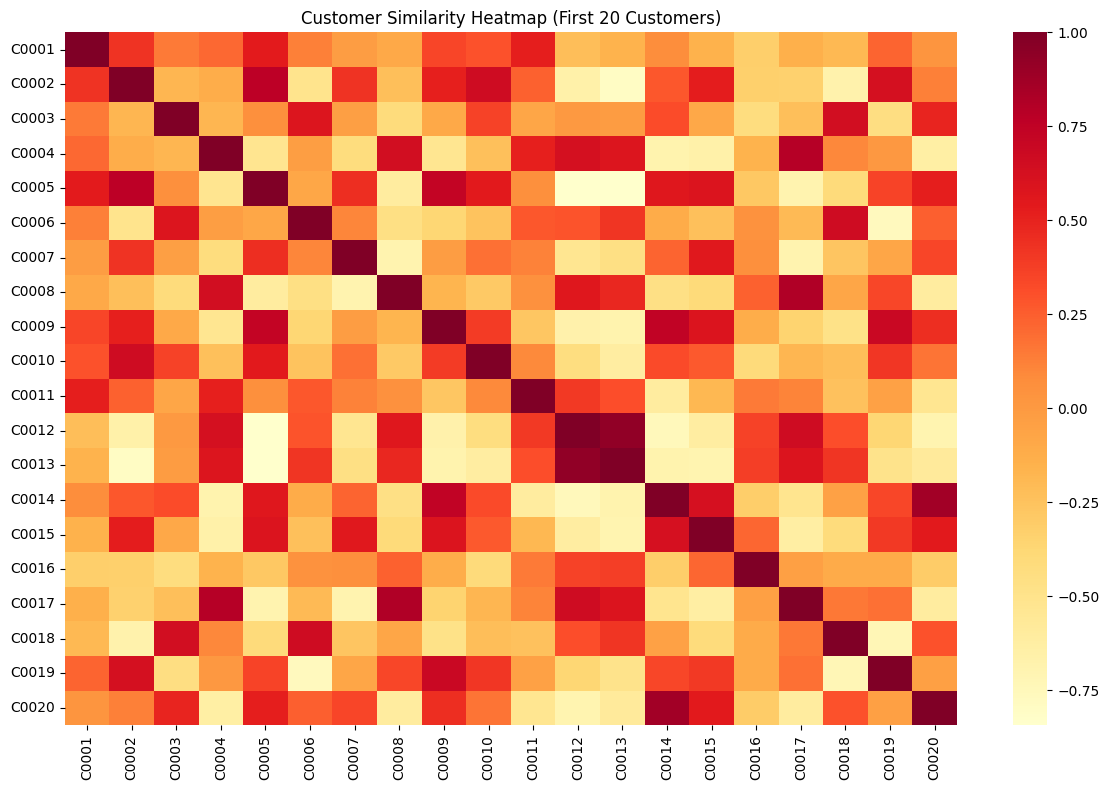

In [37]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    similarity_matrix[:20, :20],
    xticklabels=customer_features['CustomerID'][:20],
    yticklabels=customer_features['CustomerID'][:20],
    cmap='YlOrRd'
)
plt.title('Customer Similarity Heatmap (First 20 Customers)')
plt.tight_layout()
plt.show()


Showing Feature importance based on variance

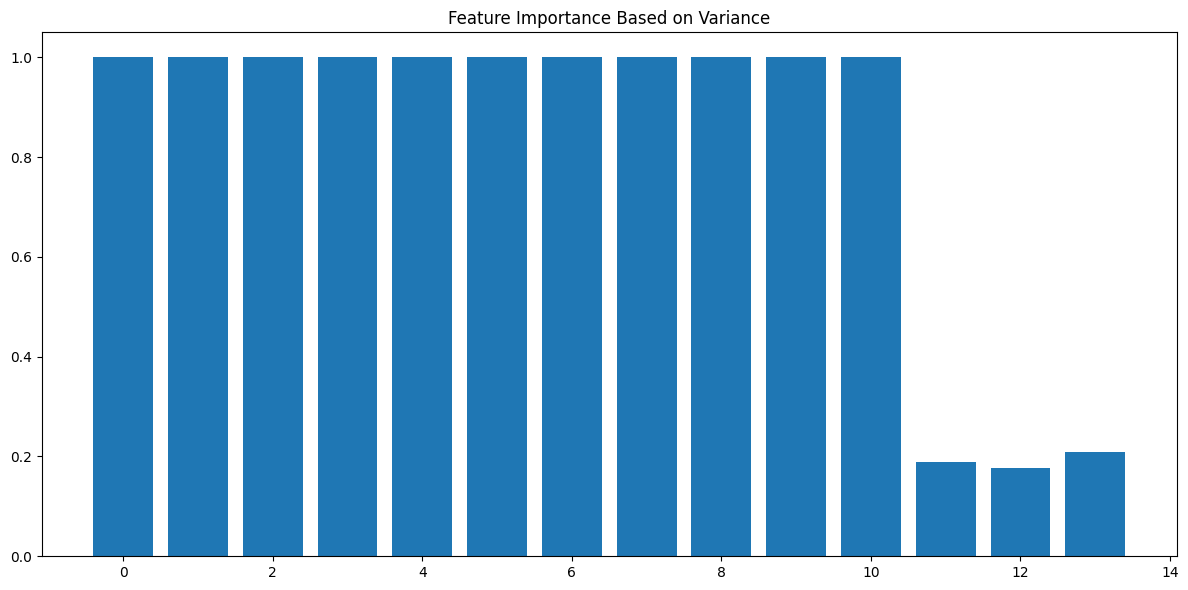

Analysis complete!


In [38]:
importance = np.var(features_processed, axis=0)
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance)), importance)
plt.title('Feature Importance Based on Variance')
plt.tight_layout()
plt.show()

print("Analysis complete!")